![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Redes Neuronales

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de redes neuronales de una capa y multicapa. El taller está constituido por 4 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción probabilidad de admisión a la universidad

En este taller se usará el conjunto de datos de admisiones a una universidad proveniente de la base de datos de Kaggle. Cada observación contiene la probabilidad de que un estudiante sea admitido por la universidad, dadas distintas variables predictoras como el puntaje del examén TOEFL y GRE, el promedio (GPA), entre otras. El objetivo es predecir la probabilidad de admissión de cada estudiante. Para más detalles pueden visitar el siguiente enlace: [datos](https://www.kaggle.com/mohansacharya/graduate-admissions).

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Importación librerías
import numpy as np
import keras
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

from keras import initializers
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Dropout

from livelossplot import PlotLossesKeras
from keras import backend as K
import keras.optimizers as opts

from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf

In [ ]:
# Carga de datos de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/universityGraduateAdmissions.csv', index_col=0)
data.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
Serial No.,,,,,,,,
1,337,118,4,4.5,4.5,9.65,1,0.92
2,324,107,4,4.0,4.5,8.87,1,0.76
3,316,104,3,3.0,3.5,8.00,1,0.72
4,322,110,3,3.5,2.5,8.67,1,0.80
5,314,103,2,2.0,3.0,8.21,0,0.65


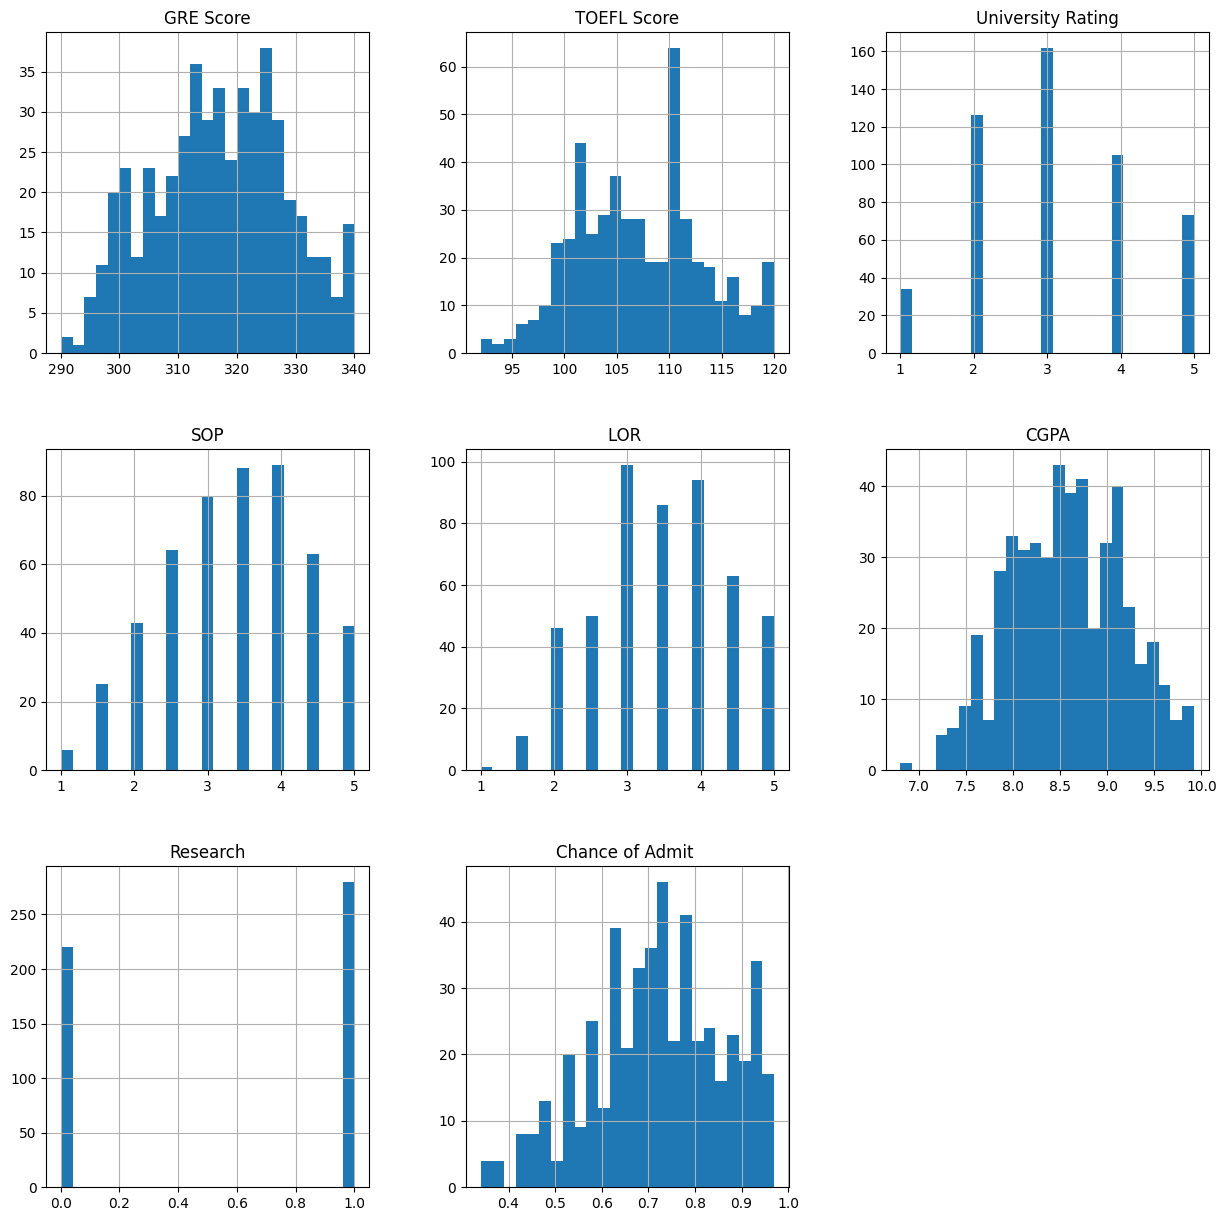

In [ ]:
# Hitogramas de las varaibles del dataset
data.hist(bins=25, figsize=(15,15))
plt.show()

In [ ]:
data.describe()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
count,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.00000
mean,316.472000,107.192000,3.114000,3.374000,3.48400,8.576440,0.560000,0.72174
std,11.295148,6.081868,1.143512,0.991004,0.92545,0.604813,0.496884,0.14114
min,290.000000,92.000000,1.000000,1.000000,1.00000,6.800000,0.000000,0.34000
25%,308.000000,103.000000,2.000000,2.500000,3.00000,8.127500,0.000000,0.63000
50%,317.000000,107.000000,3.000000,3.500000,3.50000,8.560000,1.000000,0.72000
75%,325.000000,112.000000,4.000000,4.000000,4.00000,9.040000,1.000000,0.82000
max,340.000000,120.000000,5.000000,5.000000,5.00000,9.920000,1.000000,0.97000


In [ ]:
# Definición de variables predictoras (X)
X = data.drop(data.columns[-1], axis=1)
# Definición de variable de interés (y)
Y = data[data.columns[-1]]

In [ ]:
# Separación de variables predictoras (X) y variable de interés (y) en set de entrenamiento y test usandola función train_test_split
xTrain, xTest, yTrain, yTest = train_test_split(X,Y,test_size=0.3, random_state=22)

In [ ]:
# Normalización de variables predictoras (X) con la función StandardScaler y fijación de semilla

# Definición de la función StandardScaler
scaler = StandardScaler()
scaler.fit(X)

# Transformación de los set de entrenamiento y test
xTrain = pd.DataFrame(data=scaler.transform(xTrain), columns=xTrain.columns, index=xTrain.index)
xTest = pd.DataFrame(data=scaler.transform(xTest), columns=xTest.columns, index=xTest.index)


xTrain = np.array(xTrain)
yTrain = np.array(yTrain)

xTest = np.array(xTest)
yTest = np.array(yTest)

# Plantar semilla
np.random.seed(42)
tf.random.set_seed(42)

##**Punto 1 - Red Neuronal de una capa:**

En la celda 1 creen una **red neuronal de una capa** con la librería Keras, que prediga la probabilidad de admisión de los estudiantes, usando los sets de entrenamiento y test definidos anteriormente. Pueden usar la función de perdida, el optimizador y el número de épocas que consideren pertinentes para el modelo, justificando su selección. Finalmente, grafiquen la pérdida del modelo vs el número de épocas en el set de entrenamiento y validación, y presenten el desempeño del modelo con las métricas error absoluto medio (MAE) y error cuadrático medio (MSE).

**CRITERIOS DE SELECCIÓN DE OPTIMIZADOR, FUNCIÓN DE PÉRDIDA Y NÚMEROS DE ÉPOCAS**

Según la documentación proporcionada en la página de Keras, se dispone de varios optimizadores como SGD, RMSprop, Adam, AdamW, Adadelta, Adagrad, Adamax, Adafactor, Nadam, Ftrl, Lion y Loss Scale Optimizer. De estos, se han elegido SGD, RMSprop y Adam, ya que son los más utilizados debido a su eficacia y capacidad de adaptación del learning rate [1].

En lo que respecta a la función de pérdida, se seleccionan MSE (Mean Squared Error) y MAE (Mean Absolute Error), ya que se trata de un problema de regresión, teniendo como variable de salida la Probabilidad de admisión de los estudiantes.

En cuanto a la cantidad de épocas, se opta por iniciar con 400, esperando que este valor proporcione estabilidad a los modelos. Sin embargo, se podría ajustar si alguno de ellos necesita más épocas para converger. Es importante resaltar que determinar el número de épocas es un proceso empírico y basado en la experiencia, ya que no existe un criterio único para hacerlo.


[1] https://datasmarts.net/es/que-es-un-optimizador-y-para-que-se-usa-en-deep-learning/

**RED NEURONAL DE UNA CAPA CON OPTIMIZADOR SGD, FUNCIÓN DE PÉRDIDA MSE Y 400 ÉPOCAS**

In [ ]:
# Celda 1
# Red neuronal con función de pérdida MSE y optimizador SGD
K.clear_session()

# Definición red neuronal con la función Sequential()
model = Sequential()
# Definición de la capa densa con un tamaño de salida igual a output_var y un input_shape de dims
model.add(Dense(pd.DataFrame(yTrain).shape[1], input_shape=(xTrain.shape[1],)))
# Definición de función de perdida. Se usa mean_squared_error dado que es un ejercicio de regresión
model.compile(optimizer='sgd', loss='mean_squared_error')

# Impresión de la arquitectura de la red neuronal
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 8         
                                                                 
Total params: 8 (32.00 Byte)
Trainable params: 8 (32.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


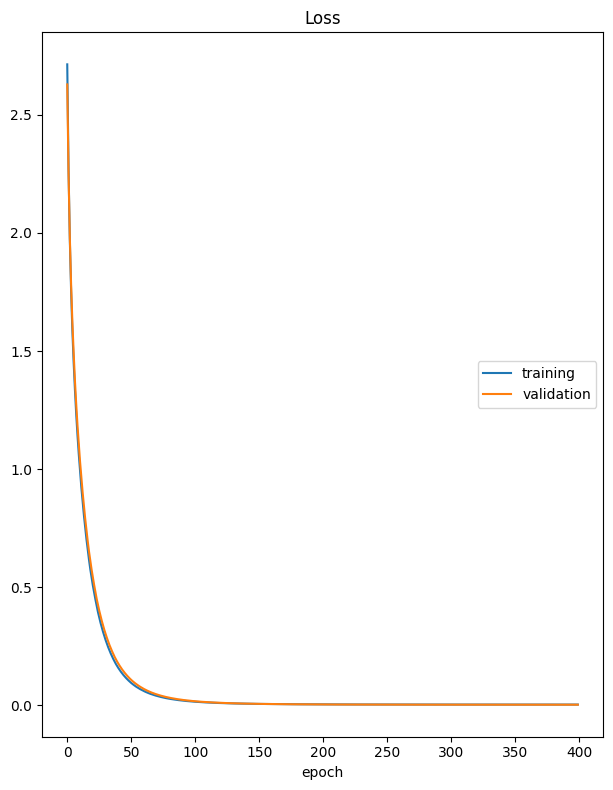

Loss
	training         	 (min:    0.004, max:    2.713, cur:    0.004)
	validation       	 (min:    0.003, max:    2.628, cur:    0.003)
3/3 [==============================] - 0s 209ms/step - loss: 0.0038 - val_loss: 0.0032


In [ ]:
# Entrenamiento de la red neuronal con 400 épocas
model.fit(xTrain, yTrain,
          verbose=True,
          epochs=400,
          batch_size=128,
          validation_data=(xTest, yTest),
          callbacks=[PlotLossesKeras()])

In [ ]:
# Predicciones del modelo
y_pred = model.predict(xTest)

# Calcular el MSE
mse_1_MSE_SGD = mean_squared_error(yTest, y_pred)
print("MSE Red neuronal con función de pérdida MSE y optimizador SGD:", mse_1_MSE_SGD)

# Calcular el MAE
mae_1_MSE_SGD = mean_absolute_error(yTest, y_pred)
print("MAE Red neuronal con función de pérdida MSE y optimizador SGD:", mae_1_MSE_SGD)

5/5 [==============================] - 0s 2ms/step
MSE Red neuronal con función de pérdida MSE y optimizador SGD: 0.0031718479717593763
MAE Red neuronal con función de pérdida MSE y optimizador SGD: 0.04112866793473562


**RED NEURONAL DE UNA CAPA CON OPTIMIZADOR SGD, FUNCIÓN DE PÉRDIDA MAE Y 400 ÉPOCAS**

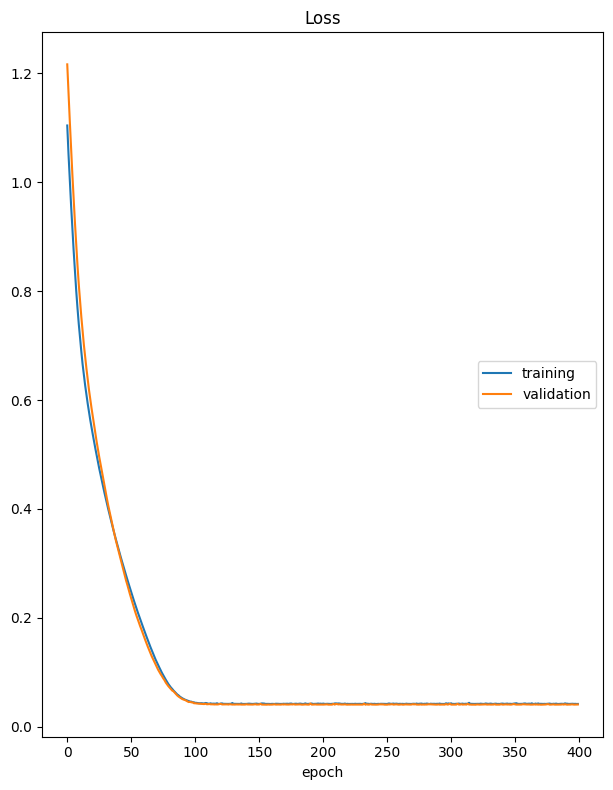

Loss
	training         	 (min:    0.042, max:    1.104, cur:    0.042)
	validation       	 (min:    0.041, max:    1.216, cur:    0.041)
3/3 [==============================] - 0s 189ms/step - loss: 0.0420 - val_loss: 0.0409


In [ ]:
# Red neuronal con función de pérdida MAE y optimizador SGD
K.clear_session()

# Definición red neuronal con la función Sequential()
model = Sequential()
# Definición de la capa densa con un tamaño de salida igual a output_var y un input_shape de dims
model.add(Dense(pd.DataFrame(yTrain).shape[1], input_shape=(xTrain.shape[1],)))
# Definición de función de perdida. Se usa mean_squared_error dado que es un ejercicio de regresión
model.compile(optimizer='sgd', loss='mean_absolute_error')

# Entrenamiento de la red neuronal con 400 épocas
model.fit(xTrain, yTrain,
          verbose=True,
          epochs=400,
          batch_size=128,
          validation_data=(xTest, yTest),
          callbacks=[PlotLossesKeras()])

In [ ]:
# Predicciones del modelo
y_pred = model.predict(xTest)

# Calcular el MSE
mse_1_MAE_SGD = mean_squared_error(yTest, y_pred)
print("MSE Red neuronal con función de pérdida MAE y optimizador SGD:", mse_1_MAE_SGD)

# Calcular el MAE
mae_1_MAE_SGD = mean_absolute_error(yTest, y_pred)
print("MAE Red neuronal con función de pérdida MAE y optimizador SGD:", mae_1_MAE_SGD)

5/5 [==============================] - 0s 2ms/step
MSE Red neuronal con función de pérdida MAE y optimizador SGD: 0.0034152332412845446
MAE Red neuronal con función de pérdida MAE y optimizador SGD: 0.04090998632113139


**RED NEURONAL DE UNA CAPA CON OPTIMIZADOR RMSPROP, FUNCIÓN DE PÉRDIDA MAE Y 400 ÉPOCAS**

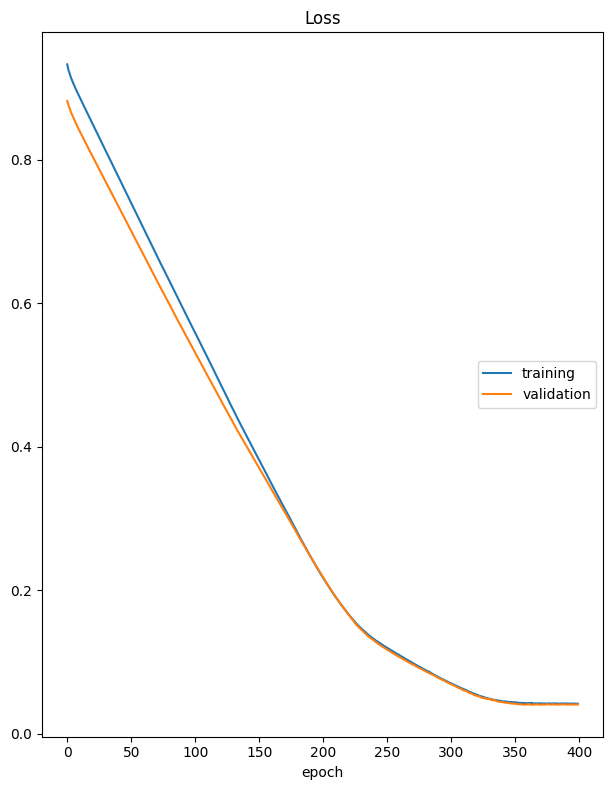

Loss
	training         	 (min:    0.042, max:    0.933, cur:    0.042)
	validation       	 (min:    0.041, max:    0.882, cur:    0.041)
3/3 [==============================] - 0s 187ms/step - loss: 0.0419 - val_loss: 0.0408


In [ ]:
# Red neuronal con función de pérdida MAE y optimizador RMSprop

K.clear_session()

# Definición red neuronal con la función Sequential()
model = Sequential()
# Definición de la capa densa con un tamaño de salida igual a output_var y un input_shape de dims
model.add(Dense(pd.DataFrame(yTrain).shape[1], input_shape=(xTrain.shape[1],)))
# Definición de función de perdida. Se usa mean_absolute_error dado que es un ejercicio de regresión
model.compile(optimizer='RMSprop', loss='mean_absolute_error')

# Entrenamiento de la red neuronal con 400 épocas
model.fit(xTrain, yTrain,
          verbose=True,
          epochs=400,
          batch_size=128,
          validation_data=(xTest, yTest),
          callbacks=[PlotLossesKeras()])

In [ ]:
# Predicciones del modelo
y_pred = model.predict(xTest)

# Calcular el MSE
mse_1_MAE_RMSprop = mean_squared_error(yTest, y_pred)
print("MSE Red neuronal con función de pérdida MAE y optimizador RMSprop:", mse_1_MAE_RMSprop)

# Calcular el MAE
mae_1_MAE_RMSprop = mean_absolute_error(yTest, y_pred)
print("MAE Red neuronal con función de pérdida MAE y optimizador RMSprop:", mae_1_MAE_RMSprop)

5/5 [==============================] - 0s 3ms/step
MSE Red neuronal con función de pérdida MAE y optimizador RMSprop: 0.003390594517091988
MAE Red neuronal con función de pérdida MAE y optimizador RMSprop: 0.04082167479197185


**RED NEURONAL DE UNA CAPA CON OPTIMIZADOR RMSPROP, FUNCIÓN DE PÉRDIDA MSE Y 400 ÉPOCAS**

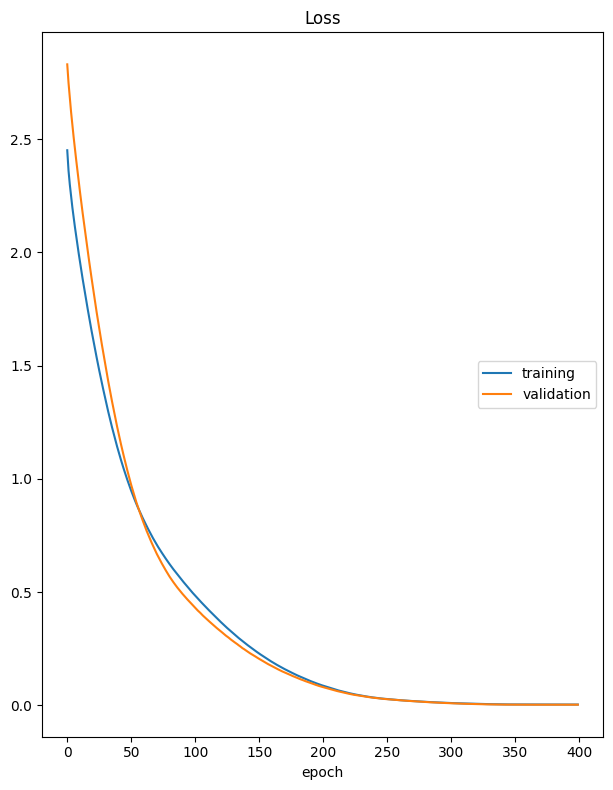

Loss
	training         	 (min:    0.004, max:    2.451, cur:    0.004)
	validation       	 (min:    0.003, max:    2.830, cur:    0.003)
3/3 [==============================] - 0s 230ms/step - loss: 0.0038 - val_loss: 0.0032


In [ ]:
# Red neuronal con función de pérdida MSE y optimizador RMSprop

K.clear_session()

# Definición red neuronal con la función Sequential()
model = Sequential()
# Definición de la capa densa con un tamaño de salida igual a output_var y un input_shape de dims
model.add(Dense(pd.DataFrame(yTrain).shape[1], input_shape=(xTrain.shape[1],)))
# Definición de función de perdida. Se usa mean_squared_error dado que es un ejercicio de regresión
model.compile(optimizer='RMSprop', loss='mean_squared_error')

# Entrenamiento de la red neuronal con 400 épocas
model.fit(xTrain, yTrain,
          verbose=True,
          epochs=400,
          batch_size=128,
          validation_data=(xTest, yTest),
          callbacks=[PlotLossesKeras()])

In [ ]:
# Predicciones del modelo
y_pred = model.predict(xTest)

# Calcular el MSE
mse_1_MSE_RMSprop = mean_squared_error(yTest, y_pred)
print("MSE Red neuronal con función de pérdida MSE y optimizador RMSprop:", mse_1_MSE_RMSprop)

# Calcular el MAE
mae_1_MSE_RMSprop = mean_absolute_error(yTest, y_pred)
print("MAE Red neuronal con función de pérdida MSE y optimizador RMSprop:", mae_1_MSE_RMSprop)

5/5 [==============================] - 0s 2ms/step
MSE Red neuronal con función de pérdida MSE y optimizador RMSprop: 0.0031518353179502373
MAE Red neuronal con función de pérdida MSE y optimizador RMSprop: 0.04089596033891042


**RED NEURONAL DE UNA CAPA CON OPTIMIZADOR ADAM, FUNCIÓN DE PÉRDIDA MAE Y 400 ÉPOCAS**

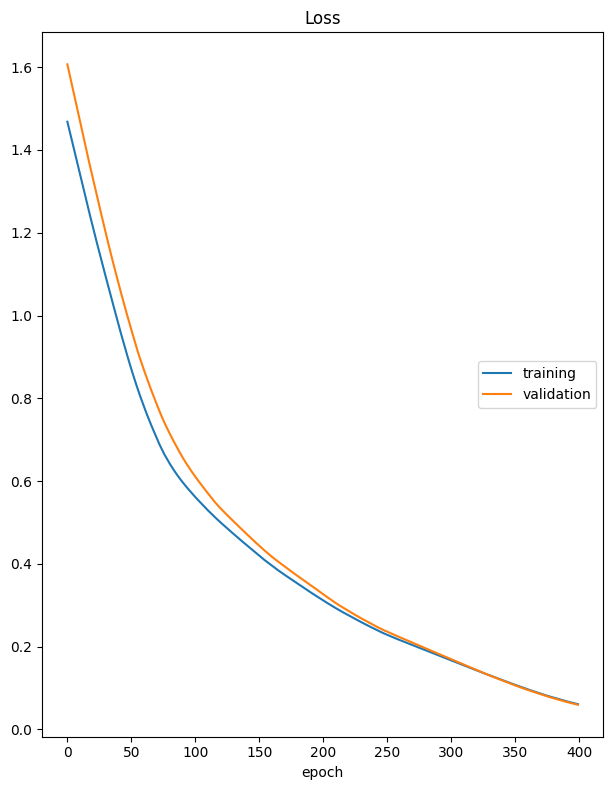

Loss
	training         	 (min:    0.061, max:    1.468, cur:    0.061)
	validation       	 (min:    0.060, max:    1.607, cur:    0.060)
3/3 [==============================] - 0s 220ms/step - loss: 0.0610 - val_loss: 0.0598


In [ ]:
# Red neuronal con función de pérdida MAE y optimizador ADAM

K.clear_session()

# Definición red neuronal con la función Sequential()
model = Sequential()
# Definición de la capa densa con un tamaño de salida igual a output_var y un input_shape de dims
model.add(Dense(pd.DataFrame(yTrain).shape[1], input_shape=(xTrain.shape[1],)))
# Definición de función de perdida. Se usa mean_absolute_error dado que es un ejercicio de regresión
model.compile(optimizer='Adam', loss='mean_absolute_error')

# Entrenamiento de la red neuronal con 400 épocas
model.fit(xTrain, yTrain,
          verbose=True,
          epochs=400,
          batch_size=128,
          validation_data=(xTest, yTest),
          callbacks=[PlotLossesKeras()])

In [ ]:
# Predicciones del modelo
y_pred = model.predict(xTest)

# Calcular el MSE
mse_1_MAE_ADAM = mean_squared_error(yTest, y_pred)
print("MSE Red neuronal con función de pérdida MAE y optimizador Adam:", mse_1_MAE_ADAM)

# Calcular el MAE
mae_1_MAE_ADAM = mean_absolute_error(yTest, y_pred)
print("MAE Red neuronal con función de pérdida MAE y optimizador Adam:", mae_1_MAE_ADAM)

5/5 [==============================] - 0s 2ms/step
MSE Red neuronal con función de pérdida MAE y optimizador Adam: 0.005777082414691817
MAE Red neuronal con función de pérdida MAE y optimizador Adam: 0.05979977373282116


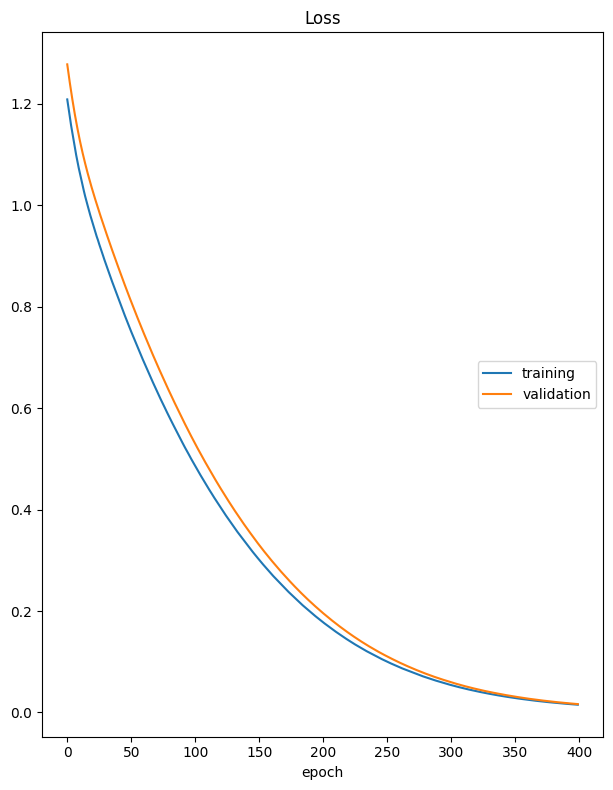

Loss
	training         	 (min:    0.015, max:    1.208, cur:    0.015)
	validation       	 (min:    0.017, max:    1.277, cur:    0.017)
3/3 [==============================] - 1s 341ms/step - loss: 0.0154 - val_loss: 0.0166


In [ ]:
# Red neuronal con función de pérdida MSE y optimizador ADAM

K.clear_session()

# Definición red neuronal con la función Sequential()
model = Sequential()
# Definición de la capa densa con un tamaño de salida igual a output_var y un input_shape de dims
model.add(Dense(pd.DataFrame(yTrain).shape[1], input_shape=(xTrain.shape[1],)))
# Definición de función de perdida. Se usa mean_squared_error dado que es un ejercicio de regresión
model.compile(optimizer='Adam', loss='mean_squared_error')

# Entrenamiento de la red neuronal con 400 épocas
model.fit(xTrain, yTrain,
          verbose=True,
          epochs=400,
          batch_size=128,
          validation_data=(xTest, yTest),
          callbacks=[PlotLossesKeras()])

In [ ]:
# Predicciones del modelo
y_pred = model.predict(xTest)

# Calcular el MSE
mse_1_MSE_ADAM = mean_squared_error(yTest, y_pred)
print("MSE Red neuronal con función de pérdida MSE y optimizador Adam:", mse_1_MSE_ADAM)

# Calcular el MAE
mae_1_MSE_ADAM = mean_absolute_error(yTest, y_pred)
print("MAE Red neuronal con función de pérdida MSE y optimizador Adam:", mae_1_MSE_ADAM)

5/5 [==============================] - 0s 3ms/step
MSE Red neuronal con función de pérdida MSE y optimizador Adam: 0.016556742113118854
MAE Red neuronal con función de pérdida MSE y optimizador Adam: 0.10158215526739757


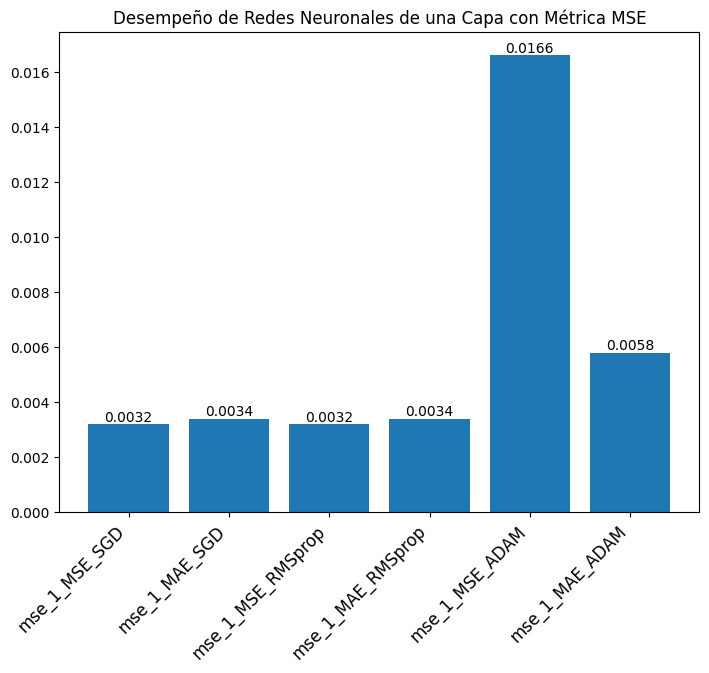

In [ ]:
#Convención para el nombre de variable: <métrica>_<numeral_taller>_<función_de_pérdida>_<optimizador> // Ej. mse_1_MSE_SGD : Métrica MSE para optimizador SGD con función de pérdida MSE.

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Desempeño de Redes Neuronales de una Capa con Métrica MSE")
ejeX = ['mse_1_MSE_SGD','mse_1_MAE_SGD', 'mse_1_MSE_RMSprop', 'mse_1_MAE_RMSprop', 'mse_1_MSE_ADAM', 'mse_1_MAE_ADAM']
ejeY = [round(mse_1_MSE_SGD,4), round(mse_1_MAE_SGD,4), round(mse_1_MSE_RMSprop, 4), round(mse_1_MAE_RMSprop, 4), round(mse_1_MSE_ADAM, 4), round(mse_1_MAE_ADAM, 4)]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i], ha='center', va='bottom', fontsize=10)
addlabels(ejeX,ejeY,plt)
plt.xticks(rotation=45, fontsize=12, ha='right')
plt.show()

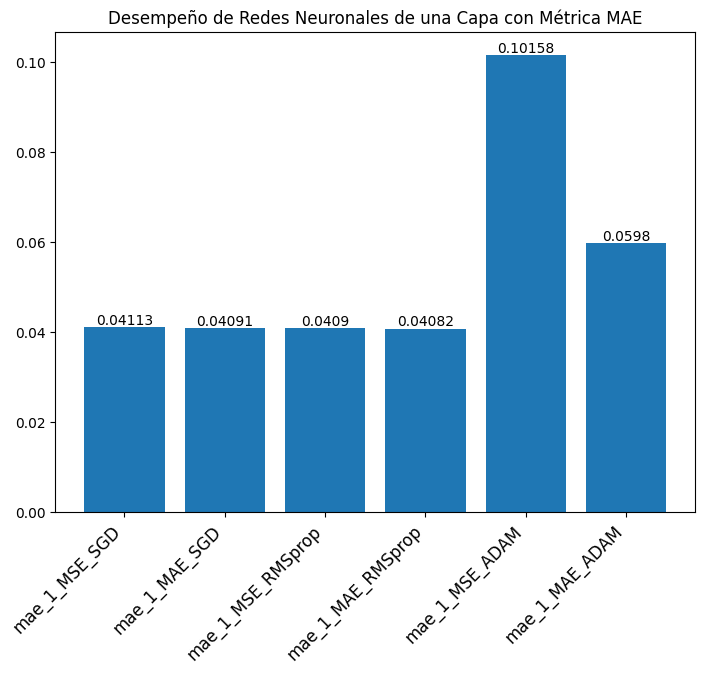

In [ ]:
#Convención para el nombre de variable: <métrica>_<numeral_taller>_<función_de_pérdida>_<optimizador> // Ej. mae_1_MSE_ADAM : Métrica MAE para optimizador ADAM con función de pérdida MSE.

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Desempeño de Redes Neuronales de una Capa con Métrica MAE")
ejeX = ['mae_1_MSE_SGD','mae_1_MAE_SGD', 'mae_1_MSE_RMSprop', 'mae_1_MAE_RMSprop', 'mae_1_MSE_ADAM', 'mae_1_MAE_ADAM']
ejeY = [round(mae_1_MSE_SGD,5), round(mae_1_MAE_SGD,5), round(mae_1_MSE_RMSprop, 5), round(mae_1_MAE_RMSprop, 5), round(mae_1_MSE_ADAM, 5), round(mae_1_MAE_ADAM, 5)]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i], ha='center', va='bottom', fontsize=10)
addlabels(ejeX,ejeY,plt)
plt.xticks(rotation=45, fontsize=12, ha='right')
plt.show()

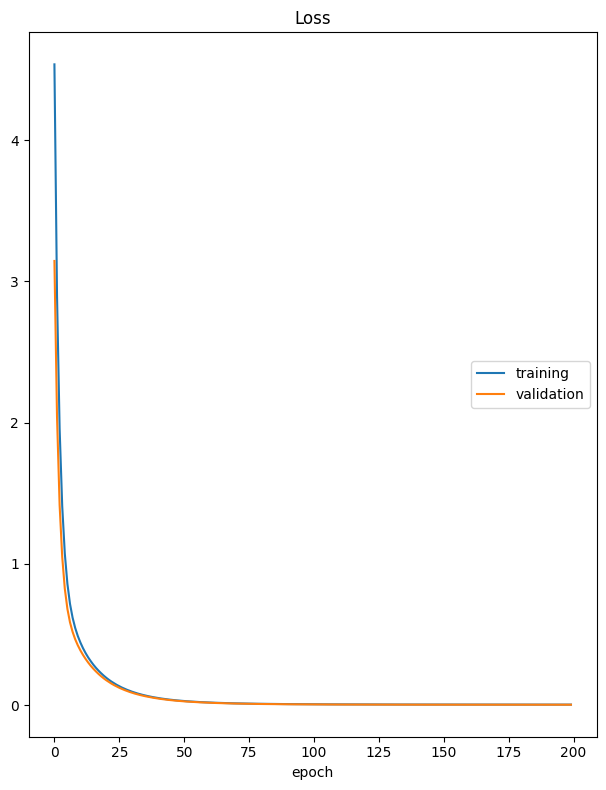

Loss
	training         	 (min:    0.004, max:    4.537, cur:    0.004)
	validation       	 (min:    0.003, max:    3.145, cur:    0.003)
5/5 [==============================] - 0s 3ms/step
MSE Red neuronal con función de pérdida MSE y optimizador SGD: 0.003159675759120445
MAE Red neuronal con función de pérdida MSE y optimizador SGD: 0.040843043963114424


In [ ]:
# Red neuronal con valores óptimos: Función de pérdida MSE, optimizador SGD y 200 épocas.
K.clear_session()

# Definición red neuronal con la función Sequential()
model = Sequential()
# Definición de la capa densa con un tamaño de salida igual a output_var y un input_shape de dims
model.add(Dense(pd.DataFrame(yTrain).shape[1], input_shape=(xTrain.shape[1],)))
# Definición de función de perdida. Se usa mean_squared_error dado que es un ejercicio de regresión
model.compile(optimizer='sgd', loss='mean_squared_error')

# Impresión de la arquitectura de la red neuronal
print(model.summary())


# Entrenamiento de la red neuronal con 200 épocas
model.fit(xTrain, yTrain,
          verbose=True,
          epochs=200,
          batch_size=128,
          validation_data=(xTest, yTest),
          callbacks=[PlotLossesKeras()])


# Predicciones del modelo
y_pred = model.predict(xTest)

# Calcular el MSE
mse_1_MSE_SGD = mean_squared_error(yTest, y_pred)
print("MSE Red neuronal con función de pérdida MSE y optimizador SGD:", mse_1_MSE_SGD)

# Calcular el MAE
mae_1_MSE_SGD = mean_absolute_error(yTest, y_pred)
print("MAE Red neuronal con función de pérdida MSE y optimizador SGD:", mae_1_MSE_SGD)

**CONCLUSIONES**

Después de analizar las métricas de MSE y MAE para las diversas combinaciones de optimizadores como SGD, RMSprop y ADAM, junto con las distintas funciones de pérdida como MSE y MAE, se observa que si la métrica analizada es MSE, la mejor combinación es RMSprop con función de pérdida MSE y una métrica MSE de 0.003151, muy ligeramente por debajo de SGD con la misma función de pérdida MSE y una métrica MSE de 0.003171. En cambio, si la métrica elegida es MAE, la mejor combinación es RMSprop con función de pérdida MAE y una métrica MAE de 0.04082, seguido de RMSprop con función de pérdida MSE y una métrica MAE de 0.04089, apenas por debajo de la métrica de SGD con función de pérdida MAE, que alcanza un MAE de 0.04090.

Además, se observó que la función de pérdida MSE, sin importar el optimizador utilizado, conduce al modelo a alcanzar la zona de mínimo error en un número significativamente menor de épocas en comparación con el uso de la función de pérdida MAE con los mismos optimizadores.

Para elegir la mejor función de pérdida para el modelo de regresión [MAE, MSE], se deben considerar ventajas y desventajas de cada una. El MAE, por un lado, ofrece una evaluación sencilla y resulta siendo útil cuando se tienen datos con valores atípicos, ya que no penaliza las predicciones con errores elevados. No obstante, su falta de diferenciabilidad en cero puede representar un desafío para los algoritmos que usen este parámetro para optimizar. Por otro lado, el MSE tiene la capacidad de eliminar valores atípicos al penalizar sus errores de predicción dentro del modelo como consecuencia de elevarlos al cuadrado, asignándoles más peso, pero esto puede a su vez representar una desventaja, ya que magnifica el error y puede ralentizar el entrenamiento del modelo [2].
Sin embargo, este no fue el caso para el conjunto de datos de este ejercicio, debido a la ausencia de datos atípicos [Ver Estadística Descriptiva en la celda 5].

Basándonos en lo expuesto anteriormente y en las combinaciones óptimas previamente mencionadas, así como en el número de épocas necesarias para alcanzar la zona de mínimo error de cada modelo, hemos seleccionado SGD con función de pérdida MSE como la opción más eficiente. Este modelo logró alcanzar la zona de mínimo error en aproximadamente 200 épocas, mientras que los otros requerían alrededor de 400 o más, lo que representa un mayor costo computacional.

Por lo anterior, se evaluó finalmente el modelo SGD con función de pérdida MSE, ajustando el número de épocas a 200 y obteniendo las métricas de desempeño MSE de 0.003 y MAE de 0.041. Cabe mencionar que el número óptimo de épocas en el cual el modelo alcanza la zona de mínimo error se tomó visualmente.

[2] https://www.growupcr.com/post/metricas-precision

## Punto 2 - Red Neuronal multicapa

En la celda 2 creen una **red neuronal con dos capas** con la librería Keras, que prediga la probabilidad de admisión de los estudiantes usando los sets de entrenamiento y test definidos anteriormente. Pueden usar la función de perdida, el optimizador, el número de épocas y el número de neuronas que consideren pertinentes para el modelo, justificando su selección. Finalmente, grafiquen la pérdida del modelo vs el número de épocas en el set de entrenamiento y validación, y presenten el desempeño del modelo con las métricas error absoluto medio (MAE) y error cuadrático medio (MSE).

**CREACIÓN DE RED NEURONAL DE DOS CAPAS**

Partiendo de la elección del modelo SGD con función de pérdida MSE del punto anterior como la opción de modelo más eficiente, procedemos a crear una red neuronal de dos capas, configurando el número de neuronas como hiperparámetro de la capa oculta, probando varios valores y empleando la función de activación ReLU [Rectified Linear Unit].

In [ ]:
# Celda 2
# Red neuronal con función de pérdida MSE, optimizador SGD y 1 capa oculta de 256 neuronas
K.clear_session()

# Definición red neuronal con la función Sequential()
model = Sequential()
# Definición de la capa densa
model.add(Dense(256, input_shape=(xTrain.shape[1],), activation = 'relu'))
model.add(Dense(pd.DataFrame(yTrain).shape[1]))
model.add(Activation('relu'))

# Impresión de la arquitectura de la red neuronal
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               2048      
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 2305 (9.00 KB)
Trainable params: 2305 (9.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


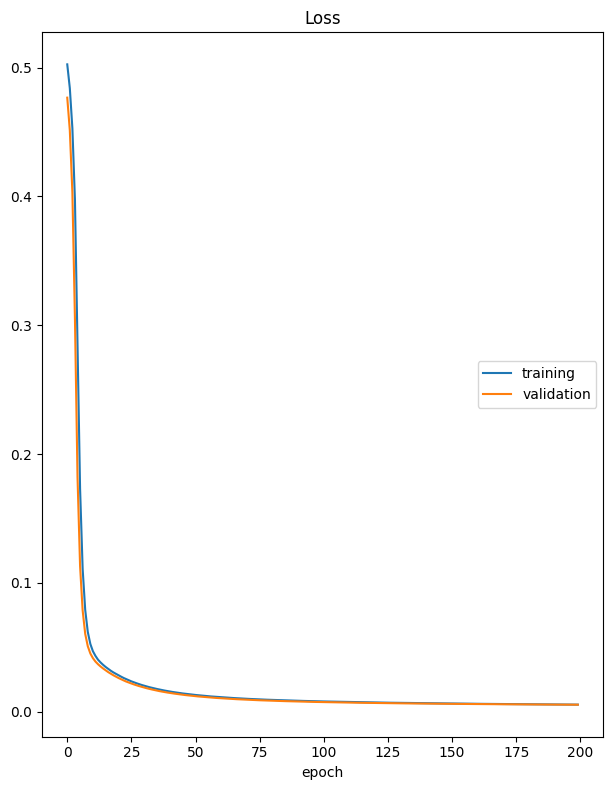

Loss
	training         	 (min:    0.005, max:    0.502, cur:    0.005)
	validation       	 (min:    0.005, max:    0.477, cur:    0.005)
3/3 [==============================] - 0s 186ms/step - loss: 0.0055 - val_loss: 0.0054


In [ ]:
# Definición de función de pérdida
model.compile(optimizer='sgd', loss='mean_squared_error')

# Entrenamiento de la red neuronal con 200 épocas
model.fit(xTrain, yTrain,
          verbose=True,
          epochs=200,
          batch_size=128,
          validation_data=(xTest, yTest),
          callbacks=[PlotLossesKeras()])

In [ ]:
# Predicciones del modelo
y_pred = model.predict(xTest)

# Calcular el MSE
mse_2_256 = mean_squared_error(yTest, y_pred)
print("MSE Red neuronal con función de pérdida MSE, 200 épocas, optimizador SGD y 256 neuronas en la capa oculta:", mse_2_256)

# Calcular el MAE
mae_2_256 = mean_absolute_error(yTest, y_pred)
print("MAE Red neuronal con función de pérdida MSE, 200 épocas y optimizador SGD y 256 neuronas en la capa oculta:", mae_2_256)

5/5 [==============================] - 0s 3ms/step
MSE Red neuronal con función de pérdida MSE, 200 épocas, optimizador SGD y 256 neuronas en la capa oculta: 0.005406687996255965
MAE Red neuronal con función de pérdida MSE, 200 épocas y optimizador SGD y 256 neuronas en la capa oculta: 0.0571859664440155


In [ ]:
# Red neuronal con función de pérdida MSE, optimizador SGD y 1 capa oculta de 512 neuronas
K.clear_session()

# Definición red neuronal con la función Sequential()
model = Sequential()
# Definición de la capa densa
model.add(Dense(512, input_shape=(xTrain.shape[1],), activation = 'relu'))
model.add(Dense(pd.DataFrame(yTrain).shape[1]))
model.add(Activation('relu'))

# Impresión de la arquitectura de la red neuronal
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               4096      
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 4609 (18.00 KB)
Trainable params: 4609 (18.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


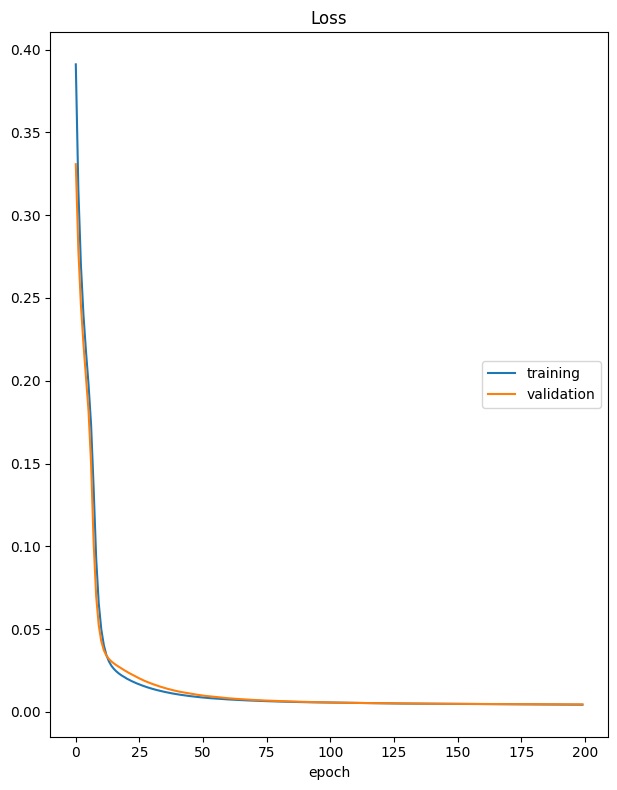

Loss
	training         	 (min:    0.004, max:    0.391, cur:    0.004)
	validation       	 (min:    0.005, max:    0.331, cur:    0.005)
3/3 [==============================] - 0s 210ms/step - loss: 0.0044 - val_loss: 0.0045


In [ ]:
# Definición de función de perdida
model.compile(optimizer='sgd', loss='mean_squared_error')

# Entrenamiento de la red neuronal con 200 épocas
model.fit(xTrain, yTrain,
          verbose=True,
          epochs=200,
          batch_size=128,
          validation_data=(xTest, yTest),
          callbacks=[PlotLossesKeras()])

In [ ]:
# Predicciones del modelo
y_pred = model.predict(xTest)

# Calcular el MSE
mse_2_512 = mean_squared_error(yTest, y_pred)
print("MSE Red neuronal con función de pérdida MSE, 200 épocas, optimizador SGD y 512 neuronas en la capa oculta:", mse_2_512)

# Calcular el MAE
mae_2_512 = mean_absolute_error(yTest, y_pred)
print("MAE Red neuronal con función de pérdida MSE, 200 épocas, optimizador SGD y 512 neuronas en la capa oculta:", mae_2_512)

5/5 [==============================] - 0s 3ms/step
MSE Red neuronal con función de pérdida MSE, 200 épocas, optimizador SGD y 512 neuronas en la capa oculta: 0.004537093081944317
MAE Red neuronal con función de pérdida MSE, 200 épocas, optimizador SGD y 512 neuronas en la capa oculta: 0.052521742018063866


In [ ]:
# Red neuronal con función de pérdida MSE, optimizador SGD y 1 capa oculta de 1024 neuronas
K.clear_session()

# Definición red neuronal con la función Sequential()
model = Sequential()
# Definición de la capa densa
model.add(Dense(1024, input_shape=(xTrain.shape[1],), activation = 'relu'))
model.add(Dense(pd.DataFrame(yTrain).shape[1]))
model.add(Activation('relu'))

# Impresión de la arquitectura de la red neuronal
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              8192      
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 9217 (36.00 KB)
Trainable params: 9217 (36.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


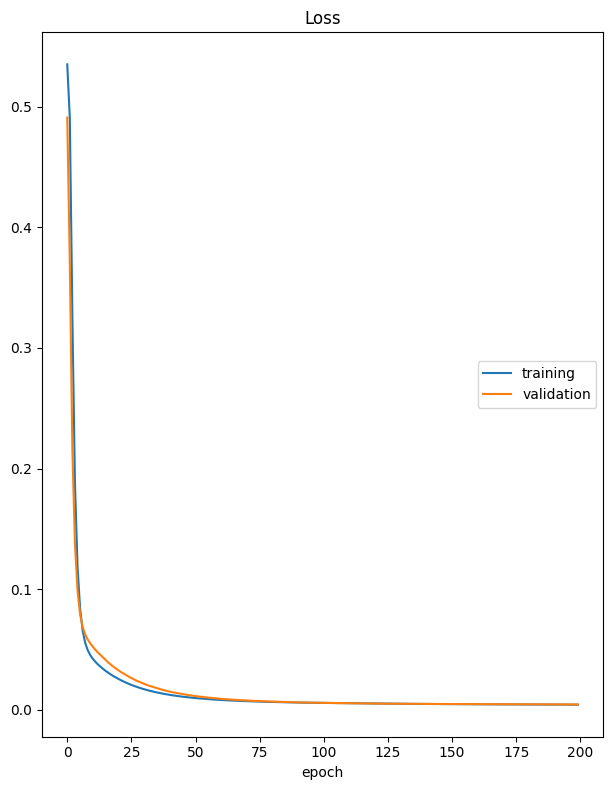

Loss
	training         	 (min:    0.004, max:    0.535, cur:    0.004)
	validation       	 (min:    0.004, max:    0.491, cur:    0.004)
3/3 [==============================] - 0s 185ms/step - loss: 0.0042 - val_loss: 0.0044


In [ ]:
# Definición de función de perdida
model.compile(optimizer='sgd', loss='mean_squared_error')

# Entrenamiento de la red neuronal con 200 épocas
model.fit(xTrain, yTrain,
          verbose=True,
          epochs=200,
          batch_size=128,
          validation_data=(xTest, yTest),
          callbacks=[PlotLossesKeras()])

In [ ]:
# Predicciones del modelo
y_pred = model.predict(xTest)

# Calcular el MSE
mse_2_1024 = mean_squared_error(yTest, y_pred)
print("MSE Red neuronal con función de pérdida MSE, 200 épocas, optimizador SGD y 1024 neuronas en la capa oculta:", mse_2_1024)

# Calcular el MAE
mae_2_1024 = mean_absolute_error(yTest, y_pred)
print("MAE Red neuronal con función de pérdida MSE, 200 épocas, optimizador SGD y 1024 neuronas en la capa oculta:", mae_2_1024)

5/5 [==============================] - 0s 4ms/step
MSE Red neuronal con función de pérdida MSE, 200 épocas, optimizador SGD y 1024 neuronas en la capa oculta: 0.004401417018118721
MAE Red neuronal con función de pérdida MSE, 200 épocas, optimizador SGD y 1024 neuronas en la capa oculta: 0.05170428426265716


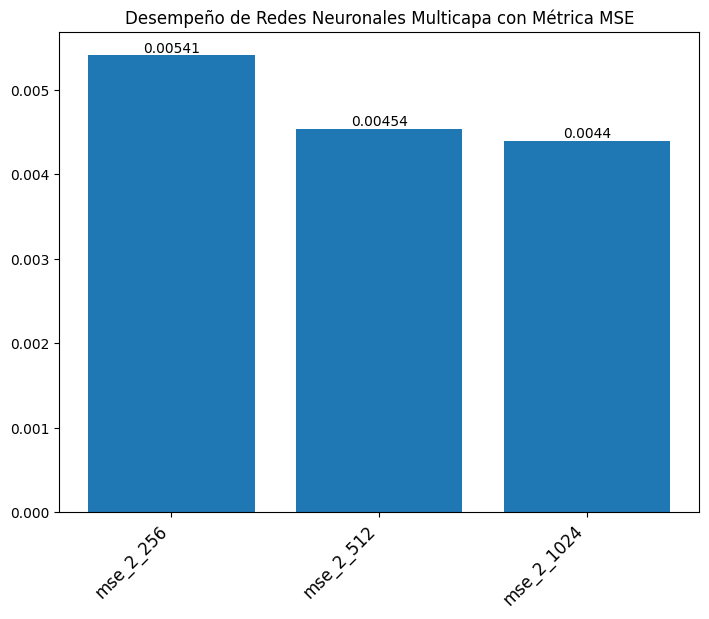

In [ ]:
#Convención para el nombre de variable: <métrica>_<numeral_taller>_<número de neuronas capa oculta> // Ej. mse_2_256 : Métrica MSE para modelo multicapa con 256 neuronas.

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Desempeño de Redes Neuronales Multicapa con Métrica MSE")
ejeX = ['mse_2_256','mse_2_512', 'mse_2_1024']
ejeY = [round(mse_2_256,5), round(mse_2_512,5), round(mse_2_1024, 5)]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i], ha='center', va='bottom', fontsize=10)
addlabels(ejeX,ejeY,plt)
plt.xticks(rotation=45, fontsize=12, ha='right')
plt.show()

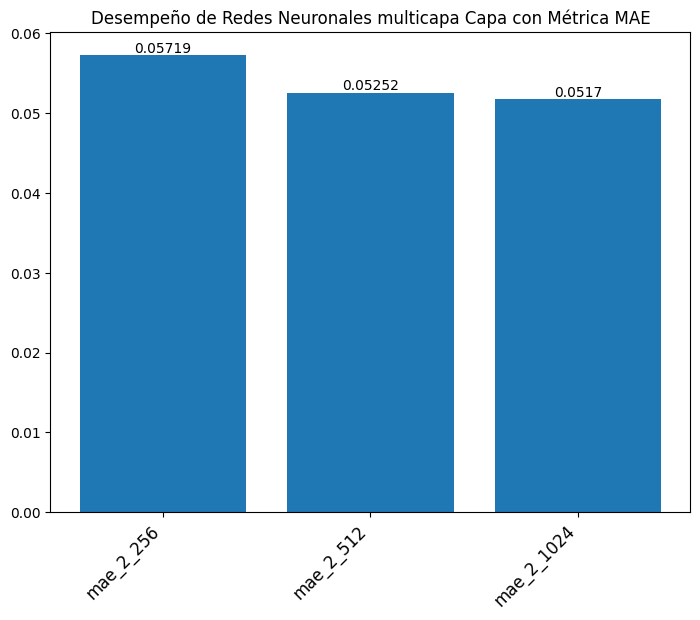

In [ ]:
#Convención para el nombre de variable: <métrica>_<numeral_taller>_<número de neuronas capa oculta> // Ej. mae_2_256 : Métrica MAE para modelo multicapa con 256 neuronas.
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Desempeño de Redes Neuronales multicapa Capa con Métrica MAE")
ejeX = ['mae_2_256','mae_2_512', 'mae_2_1024']
ejeY = [round(mae_2_256,5), round(mae_2_512,5), round(mae_2_1024, 5)]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i], ha='center', va='bottom', fontsize=10)
addlabels(ejeX,ejeY,plt)
plt.xticks(rotation=45, fontsize=12, ha='right')
plt.show()

**CONCLUSIONES**

Después de analizar las métricas de desempeño del modelo SGD con función de pérdida MSE y probando con valores de 256, 512 y 1024 neuronas como hiperparámetro y empleando la función de activación ReLU, se observa que independientemente de la métrica que se tome para analizar, ya sea MAE o MSE, el modelo que tiene el mejor desempeño es el que utilizó una mayor cantidad de neuronas, es decir 1024, obteniendo métricas MSE de 0.0044 y MAE de 0.0517. Sin embargo, incrementar el número de neuronas no siempre conlleva una mejora en el desempeño, pues aumenta el riesgo de overfitting, lo que podría comprometer la capacidad del modelo para predecir con nuevos datos.

## Punto 3  - Red Neuronal multicapa

En la celda 3 creen **una red neuronal con más de una capa con la librería Keras, usando early stopping y dropout,** que prediga la probabilidad de admisión de los estudiantes con los sets de entrenamiento y test definidos anteriormente. Pueden usar la función de perdida, el optimizador, el número de épocas y el número de neuronas que consideren pertinentes para el modelo, justificando su selección. Finalmente, grafiquen la pérdida del modelo vs el número de épocas en el set de entrenamiento y validación, y presenten el desempeño del modelo con las métricas error absoluto medio (MAE) y error cuadrático medio (MSE).

**CREACIÓN DE RED NEURONAL CON MÁS DE UNA CAPA**

Partiendo de la elección del modelo SGD con función de pérdida MSE del primer punto como la opción de modelo más eficiente, procedemos a crear una red neuronal de más de una capa, experimentando con valores de 256, 512 y 1024 neuronas como hiperparámetro para evaluar el comportamiento del modelo con diferente número de neuronas. Además, activaremos early stopping y dropout para mejorar el rendimiento del modelo.

In [ ]:
# Celda 3
# Red neuronal con función de pérdida MSE, optimizador SGD, 1 capa oculta de 1024 neuronas, early stopping y dropout

K.clear_session()

# Definición red neuronal con la función Sequential()
model = Sequential()
# Definición de la capa densa
model.add(Dense(1024, input_shape=(xTrain.shape[1],), activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(pd.DataFrame(yTrain).shape[1]))
model.add(Activation('relu'))

# Impresión de la arquitectura de la red neuronal
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              8192      
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 9217 (36.00 KB)
Trainable params: 9217 (36.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


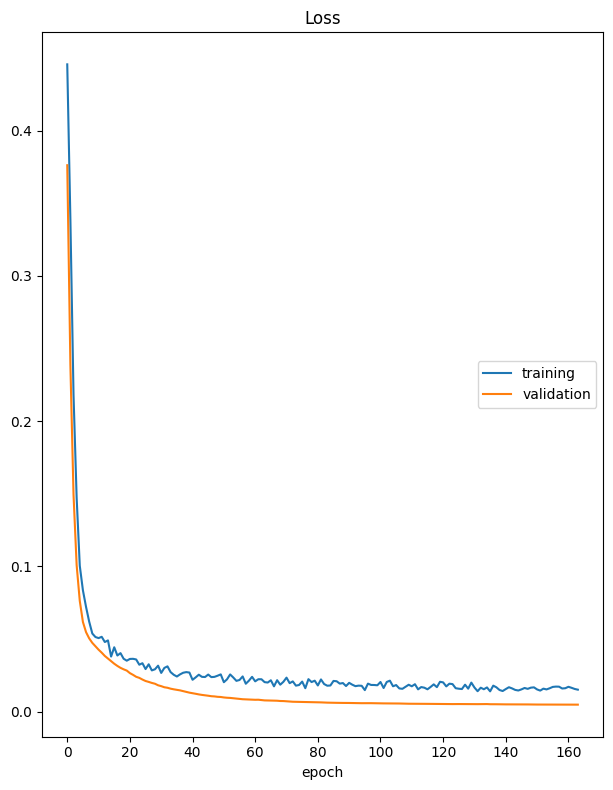

Loss
	training         	 (min:    0.014, max:    0.446, cur:    0.015)
	validation       	 (min:    0.005, max:    0.376, cur:    0.005)
3/3 [==============================] - 0s 190ms/step - loss: 0.0151 - val_loss: 0.0048
Epoch 164: early stopping


In [ ]:
# Definición de función de perdida
model.compile(optimizer='sgd', loss='mean_squared_error')

# Definición de la función EarlyStopping para considerar durante el entrenamiento
early_stop = EarlyStopping(monitor='val_loss', patience=4, verbose=1)
# Definición de la función ModelCheckpoint para guardar el modelo con mejor desempeño
fBestModel = 'best_model.keras'
best_model = ModelCheckpoint(fBestModel, verbose=0, save_best_only=True)

# Entrenamiento de la red neuronal con 200 épocas y early stopping
model.fit(xTrain, yTrain,
          verbose=True,
          epochs=200,
          batch_size=128,
          validation_data=(xTest, yTest),
          callbacks=[best_model, early_stop, PlotLossesKeras()])

In [ ]:
# Predicciones del modelo
y_pred = model.predict(xTest)

# Calcular el MSE
mse_3 = mean_squared_error(yTest, y_pred)
print("MSE Red neuronal con función de pérdida MSE, optimizador SGD, 1 capa oculta de 1024 neuronas, early stopping y dropout:", mse_3)

# Calcular el MAE
mae_3 = mean_absolute_error(yTest, y_pred)
print("MAE Red neuronal con función de pérdida MSE, optimizador SGD, 1 capa oculta de 1024 neuronas, early stopping y dropout:", mae_3)

5/5 [==============================] - 0s 3ms/step
MSE Red neuronal con función de pérdida MSE, optimizador SGD, 1 capa oculta de 1024 neuronas, early stopping y dropout: 0.004822069924105078
MAE Red neuronal con función de pérdida MSE, optimizador SGD, 1 capa oculta de 1024 neuronas, early stopping y dropout: 0.05421726710796357


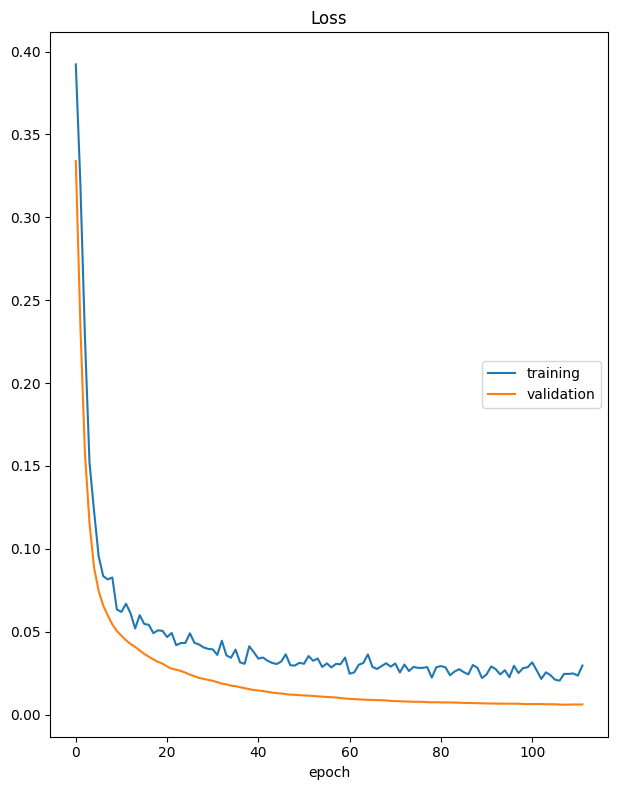

Loss
	training         	 (min:    0.021, max:    0.392, cur:    0.030)
	validation       	 (min:    0.006, max:    0.334, cur:    0.006)
3/3 [==============================] - 0s 235ms/step - loss: 0.0296 - val_loss: 0.0062
Epoch 112: early stopping
5/5 [==============================] - 0s 3ms/step
MSE Red neuronal con función de pérdida MSE, optimizador SGD, 1 capa oculta de 512 neuronas, early stopping y dropout: 0.006156085768025869
MAE Red neuronal con función de pérdida MSE, optimizador SGD, 1 capa oculta de 512 neuronas, early stopping y dropout: 0.06269757481416068


In [ ]:
## Red neuronal con función de pérdida MSE, optimizador SGD, 1 capa oculta de 512 neuronas, early stopping y dropout

K.clear_session()

# Definición red neuronal con la función Sequential()
model = Sequential()
# Definición de la capa densa
model.add(Dense(512, input_shape=(xTrain.shape[1],), activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(pd.DataFrame(yTrain).shape[1]))
model.add(Activation('relu'))

# Impresión de la arquitectura de la red neuronal
print(model.summary())

# Definición de función de perdida
model.compile(optimizer='sgd', loss='mean_squared_error')

# Definición de la función EarlyStopping para considerar durante el entrenamiento
early_stop = EarlyStopping(monitor='val_loss', patience=4, verbose=1)
# Definición de la función ModelCheckpoint para guardar el modelo con mejor desempeño
fBestModel = 'best_model.keras'
best_model = ModelCheckpoint(fBestModel, verbose=0, save_best_only=True)

# Entrenamiento de la red neuronal con 200 épocas y early stopping
model.fit(xTrain, yTrain,
          verbose=True,
          epochs=200,
          batch_size=128,
          validation_data=(xTest, yTest),
          callbacks=[best_model, early_stop, PlotLossesKeras()])

# Predicciones del modelo
y_pred = model.predict(xTest)

# Calcular el MSE
mse_3_512 = mean_squared_error(yTest, y_pred)
print("MSE Red neuronal con función de pérdida MSE, optimizador SGD, 1 capa oculta de 512 neuronas, early stopping y dropout:", mse_3_512)

# Calcular el MAE
mae_3_512 = mean_absolute_error(yTest, y_pred)
print("MAE Red neuronal con función de pérdida MSE, optimizador SGD, 1 capa oculta de 512 neuronas, early stopping y dropout:", mae_3_512)

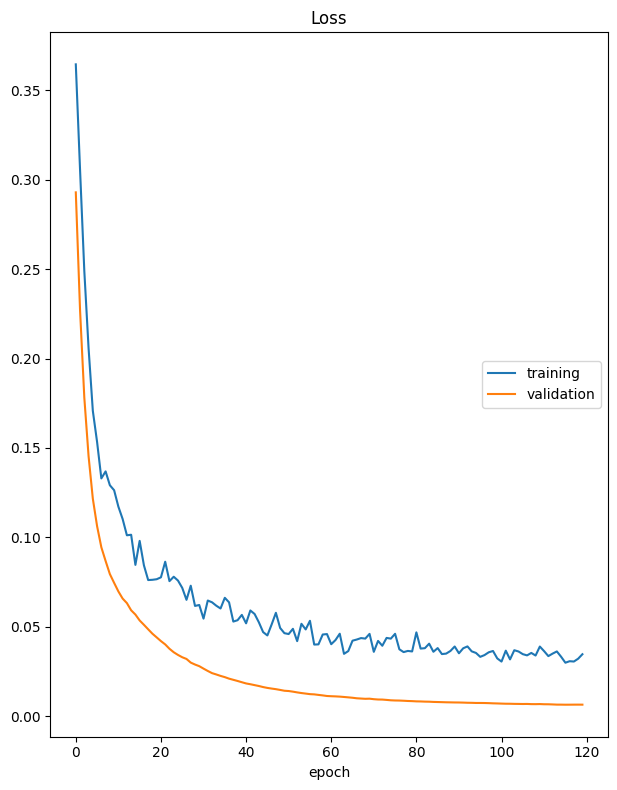

Loss
	training         	 (min:    0.030, max:    0.364, cur:    0.035)
	validation       	 (min:    0.006, max:    0.293, cur:    0.007)
3/3 [==============================] - 1s 536ms/step - loss: 0.0347 - val_loss: 0.0065
Epoch 120: early stopping
5/5 [==============================] - 0s 3ms/step
MSE Red neuronal con función de pérdida MSE, optimizador SGD, 1 capa oculta de 256 neuronas, early stopping y dropout: 0.006512294261924749
MAE Red neuronal con función de pérdida MSE, optimizador SGD, 1 capa oculta de 256 neuronas, early stopping y dropout: 0.06537889755566915


In [ ]:
## Red neuronal con función de pérdida MSE, optimizador SGD, 1 capa oculta de 256 neuronas, early stopping y dropout

K.clear_session()

# Definición red neuronal con la función Sequential()
model = Sequential()
# Definición de la capa densa
model.add(Dense(256, input_shape=(xTrain.shape[1],), activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(pd.DataFrame(yTrain).shape[1]))
model.add(Activation('relu'))

# Impresión de la arquitectura de la red neuronal
print(model.summary())

# Definición de función de perdida
model.compile(optimizer='sgd', loss='mean_squared_error')

# Definición de la función EarlyStopping para considerar durante el entrenamiento
early_stop = EarlyStopping(monitor='val_loss', patience=4, verbose=1)
# Definición de la función ModelCheckpoint para guardar el modelo con mejor desempeño
fBestModel = 'best_model.keras'
best_model = ModelCheckpoint(fBestModel, verbose=0, save_best_only=True)

# Entrenamiento de la red neuronal con 200 épocas y early stopping
model.fit(xTrain, yTrain,
          verbose=True,
          epochs=200,
          batch_size=128,
          validation_data=(xTest, yTest),
          callbacks=[best_model, early_stop, PlotLossesKeras()])

# Predicciones del modelo
y_pred = model.predict(xTest)

# Calcular el MSE
mse_3_256 = mean_squared_error(yTest, y_pred)
print("MSE Red neuronal con función de pérdida MSE, optimizador SGD, 1 capa oculta de 256 neuronas, early stopping y dropout:", mse_3_256)

# Calcular el MAE
mae_3_256 = mean_absolute_error(yTest, y_pred)
print("MAE Red neuronal con función de pérdida MSE, optimizador SGD, 1 capa oculta de 256 neuronas, early stopping y dropout:", mae_3_256)

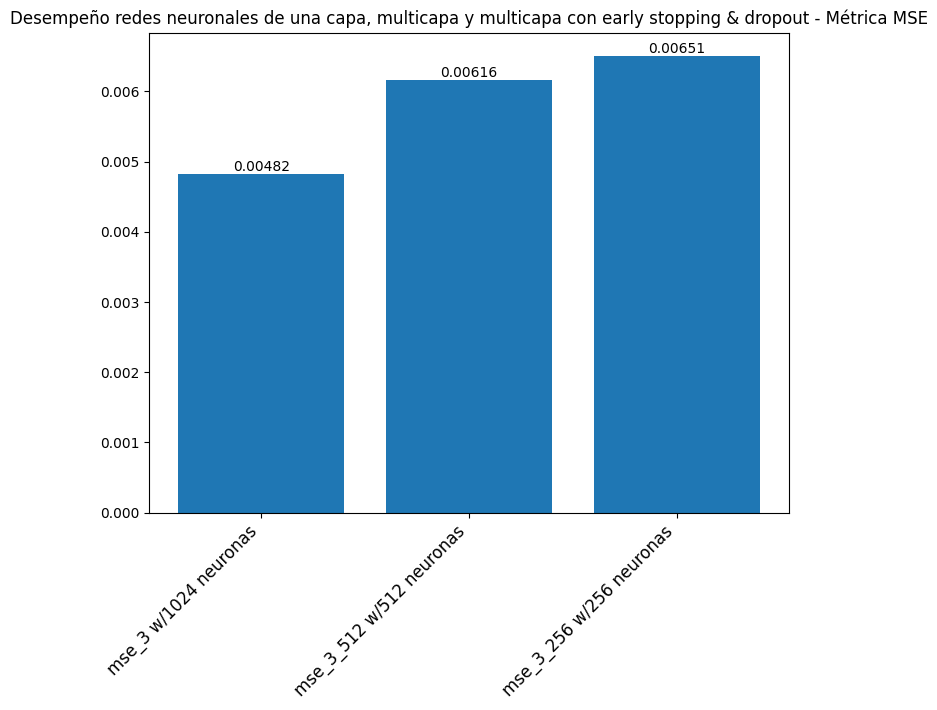

In [ ]:
#Comparación de MSE empleando distintos valores de neuronas
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Desempeño redes neuronales de una capa, multicapa y multicapa con early stopping & dropout - Métrica MSE")
ejeX = ['mse_3 w/1024 neuronas','mse_3_512 w/512 neuronas', 'mse_3_256 w/256 neuronas']
ejeY = [round(mse_3,5), round(mse_3_512,5), round(mse_3_256, 5)]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i], ha='center', va='bottom', fontsize=10)
addlabels(ejeX,ejeY,plt)
plt.xticks(rotation=45, fontsize=12, ha='right')
plt.show()

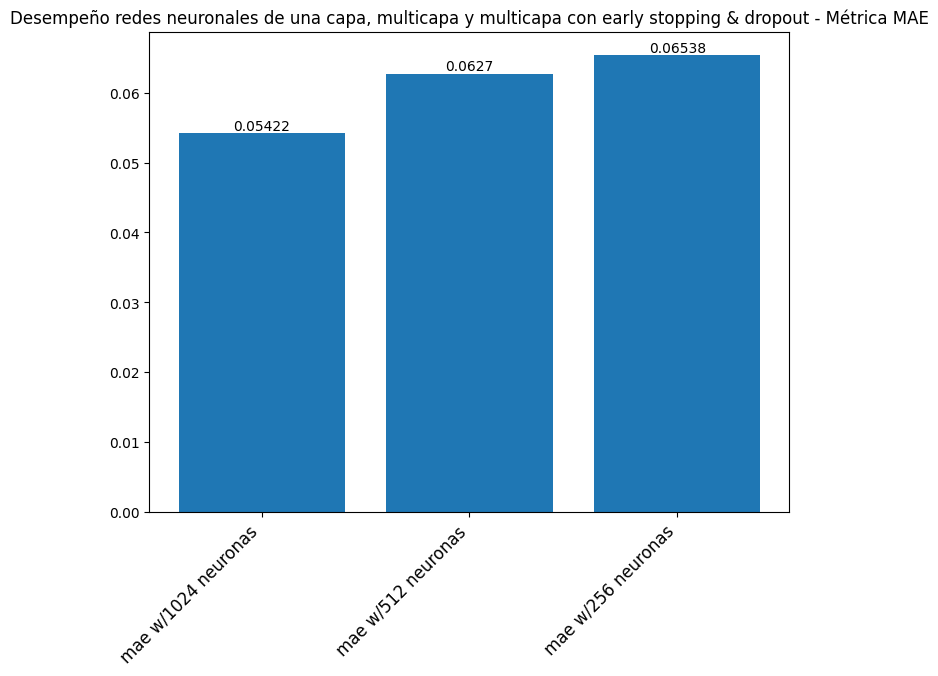

In [ ]:
#Comparación de MAE empleando distintos valores de neuronas
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Desempeño redes neuronales de una capa, multicapa y multicapa con early stopping & dropout - Métrica MAE")
ejeX = ['mae w/1024 neuronas','mae w/512 neuronas', 'mae w/256 neuronas']
ejeY = [round(mae_3,5), round(mae_3_512,5), round(mae_3_256, 5)]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i], ha='center', va='bottom', fontsize=10)
addlabels(ejeX,ejeY,plt)
plt.xticks(rotation=45, fontsize=12, ha='right')
plt.show()

**CONCLUSIONES**

Después de analizar las métricas de desempeño del modelo SGD con función de pérdida MSE y probando con valores de 256, 512 y 1024 neuronas como hiperparámetro y activando "early stopping" y "dropout" se observa que independientemente de la métrica que se tome para analizar, ya sea MAE o MSE, el modelo de más de una capa que tiene el mejor desempeño es el que utilizó una mayor cantidad de neuronas, es decir 1024, obteniendo métricas MSE de 0.00482 y MAE de 0.05422. Además, al activar "dropout", el modelo se vuelve menos propenso al overfitting al olvidar un porcentaje de lo aprendido en cada época, lo que contribuye a evitar que las curvas de entrenamiento y prueba se acerquen o converjan. Esta estrategia amortigua el riesgo de overfitting que aumenta con el número de neuronas.

También se observó que la reducción del número de neuronas en la capa oculta no necesariamente reduce el número de épocas antes del "early stopping". Esto puede deberse a diversos factores, como la cantidad de datos disponibles y la tasa de aprendizaje, entre otros. Además, al incrementar de 2 a 4 el parámetro de "patience" de esta función, le otorgó mayor flexibilidad al modelo, evitando que se detuviera prematuramente, lo cual le permitió adaptarse mejor a los datos de entrenamiento.

## Punto 4 - Comparación y análisis de resultados

En la celda 4 comparen los resultados obtenidos de las diferentes redes y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

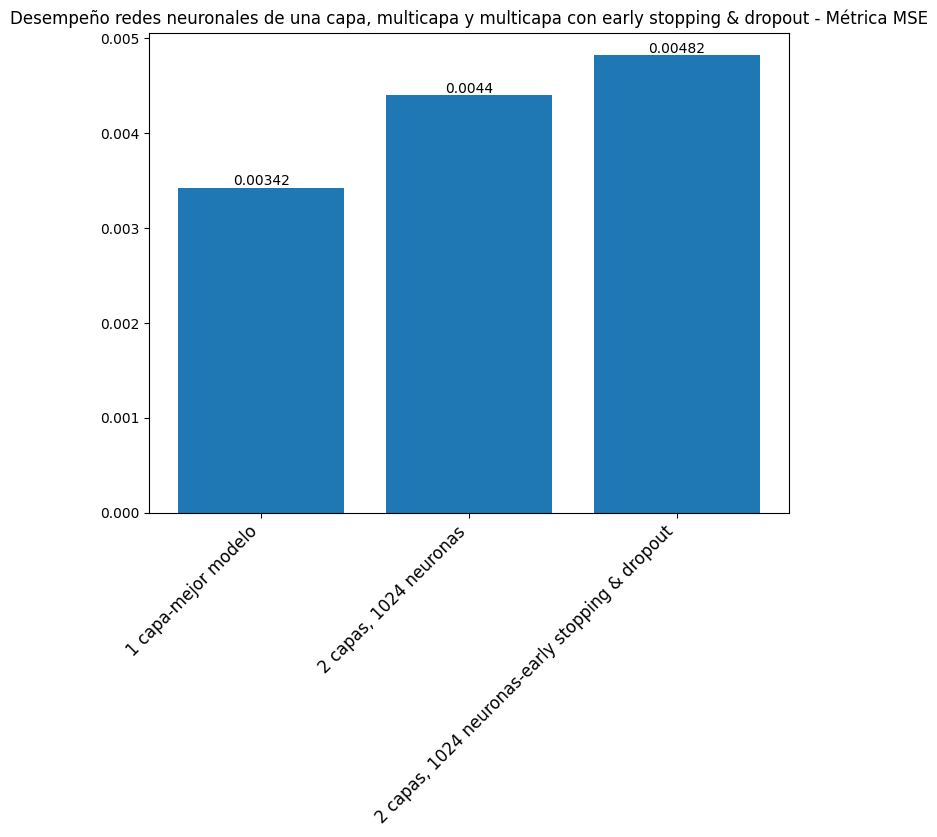

In [ ]:
#Comparación de MAE de los mejores modelos de los puntos 1, 2 y 3
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Desempeño redes neuronales de una capa, multicapa y multicapa con early stopping & dropout - Métrica MSE")
ejeX = ['1 capa-mejor modelo','2 capas, 1024 neuronas', '2 capas, 1024 neuronas-early stopping & dropout']
ejeY = [round(mse_1_MAE_SGD,5), round(mse_2_1024,5), round(mse_3, 5)]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i], ha='center', va='bottom', fontsize=10)
addlabels(ejeX,ejeY,plt)
plt.xticks(rotation=45, fontsize=12, ha='right')
plt.show()

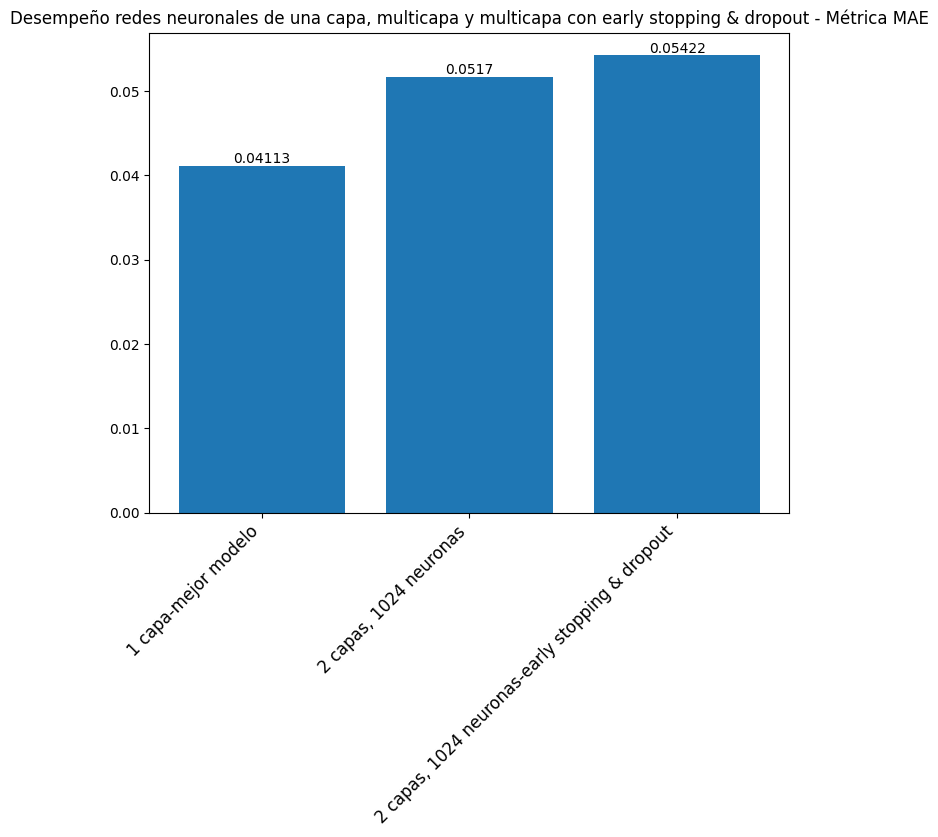

In [ ]:
#Comparación de MAE de los mejores modelos de los puntos 1, 2 y 3
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Desempeño redes neuronales de una capa, multicapa y multicapa con early stopping & dropout - Métrica MAE")
ejeX = ['1 capa-mejor modelo','2 capas, 1024 neuronas', '2 capas, 1024 neuronas-early stopping & dropout']
ejeY = [round(mae_1_MSE_SGD,5), round(mae_2_1024,5), round(mae_3, 5)]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i], ha='center', va='bottom', fontsize=10)
addlabels(ejeX,ejeY,plt)
plt.xticks(rotation=45, fontsize=12, ha='right')
plt.show()

**CONCLUSIONES**

Después de analizar detalladamente los resultados de las métricas MSE y MAE de los diversos modelos implementados, incluyendo aquellos de una y dos capas, se evidencia que el modelo de una sola capa utilizando optimizador SGD con función de pérdida MSE, muestra el mejor rendimiento, por encima de modelos más complejos de dos capas, para este set de datos en particular. Esto podría atribuirse a la capacidad de adaptabilidad de dicho modelo para abordar la diversidad de los datos de manera más eficiente debido a la naturaleza y composición de estos, los cuales no necesariamente requerían un tratamiento más riguroso como el aplicado por modelos más complejos.

Entre las ventajas del modelo de una sola capa con optimizador SGD y función de pérdida MSE se encuentra su eficiencia computacional, su capacidad para ser replicado en grandes conjuntos de datos y su adaptabilidad a cambios en la información.

Por otro lado, una desventaja del modelo multicapa que presentó el menor desempeño es que añade complejidad innecesaria en conjuntos de datos que no presentan una no linealidad tan marcada. Además, estos modelos multicapa tienen un mayor costo computacional, presentan un mayor riesgo de overfitting y requiere de un conjunto de datos bastante grande para ser más eficientes.